http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html

In [1]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
initialValue = 100
mu = 0.0
sigma = 0.2
timestep = 30
base_date = ql.Date(10, 8, 2020)
maturity = ql.Date(10, 9, 2020)
length = (maturity - base_date)/365.0 # in years
num_paths = 10000
initial_deltas = [0]*num_paths
strike = 100.0
learning_rate = 0.01

In [3]:
process = ql.GeometricBrownianMotionProcess(initialValue, mu, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(process, length, timestep, rng, False)

In [4]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

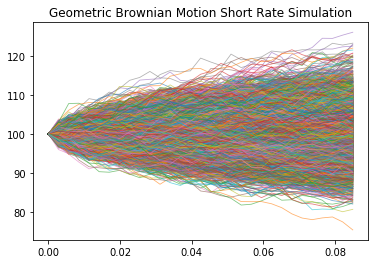

In [ ]:
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Geometric Brownian Motion Short Rate Simulation")
plt.show()

In [ ]:
paths[0]

array([100.        ,  99.72704529,  99.04403565, 101.92432043,
       102.58402805, 103.78721369, 102.91330029, 103.38029229,
       105.00411863, 103.45757389, 102.14351024, 101.78963126,
       100.60779975, 101.0646122 , 100.73662654, 100.94394492,
       101.84569966, 104.0602217 , 104.02669104, 105.99107736,
       105.37784007, 105.48081795, 104.83869091, 105.17055547,
       105.56216648, 104.95094419, 104.59338229, 103.85966949,
       103.08158945, 103.81579923, 104.98467999])

In [ ]:
time[0]

0.0

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, gamma=0.99, state_size=2, 
                 action_size=1, hidden_size=10,
                 name='QNetwork'):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [ ]:
mainQN = QNetwork(name='main')
opt = optim.Adam(mainQN.parameters(), learning_rate)

In [ ]:
def R(t, length, s_t, s_T, strike, deltas):
    tensor_s_t = torch.FloatTensor(s_t)
    tensor_s_T = torch.FloatTensor(s_T)
    tensor_deltas = torch.FloatTensor(deltas)
    if t<length:
        z = 0
    else:
        z = torch.max(torch.zeros(num_paths), tensor_s_T - strike)
    return tensor_deltas*(tensor_s_T - tensor_s_t) - z

In [ ]:
def get_actions(mainQN, paths, time_to_maturity, deltas):
    l_slice = []
    for p, d in zip(paths, deltas):
        l_slice.append([p, time_to_maturity, d])
    return mainQN(Variable(torch.FloatTensor(l_slice))).squeeze(1)

In [ ]:
for ep in range(10000):
    last_deltas = initial_deltas
    time, paths = generate_paths(num_paths, timestep)
    '''
    for i in range(0, len(time)-1):
        deltas_i = get_actions(mainQN, paths[:,i], length - time[i], last_deltas)
        reward = R(time[i+1], length, paths[:,i+1], paths[:,i], strike, deltas_i).unsqueeze(0)
        last_deltas = deltas_i
        if i==0:
            rewards = reward
            deltas = last_deltas.unsqueeze(0)
        else:
            rewards = torch.cat((rewards, reward), 0)
            deltas = torch.cat((deltas, last_deltas.unsqueeze(0)), 0)
    rewards = torch.t(rewards)
    deltas = torch.t(deltas)
    #loss = torch.abs(torch.sum(rewards,1)).mean()
    loss = -rewards.mean()
    '''
    torch_paths = torch.FloatTensor(paths)
    torch_time = torch.FloatTensor(time)
    for step in range(0, len(time)-1):    
        batch = torch.cat((torch_paths[:,step].view(-1,1), length - torch.full((num_paths,1),fill_value=torch_time[step])), 1)
        torch_delta = mainQN(Variable(batch))

        z = torch.max(torch.zeros(num_paths), torch_paths[:,-1] - strike).view(-1,1) - torch.max(torch.zeros(num_paths), torch_paths[:,step] - strike).view(-1,1)
        h = (torch_paths[:,-1] - torch_paths[:,step]).view(-1,1)*torch_delta
        
        #loss = torch.abs(-z+h).mean()
        loss = torch.nn.SmoothL1Loss()(h, z)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    if ep%100 == 0:
        print(ep, loss)

    

0 tensor(0.1814, grad_fn=<SmoothL1LossBackward>)
100 tensor(0.0435, grad_fn=<SmoothL1LossBackward>)
200 tensor(0.0434, grad_fn=<SmoothL1LossBackward>)
300 tensor(0.0420, grad_fn=<SmoothL1LossBackward>)
400 tensor(0.0393, grad_fn=<SmoothL1LossBackward>)
500 tensor(0.0350, grad_fn=<SmoothL1LossBackward>)
600 tensor(0.0316, grad_fn=<SmoothL1LossBackward>)
700 tensor(0.0302, grad_fn=<SmoothL1LossBackward>)
800 tensor(0.0277, grad_fn=<SmoothL1LossBackward>)
900 tensor(0.0234, grad_fn=<SmoothL1LossBackward>)


In [ ]:
def plt_delta(st, t):
    list_t = [t]*len(st)
    torch_st = torch.FloatTensor(st).view(-1,1)
    torch_t = torch.FloatTensor(list_t).view(-1,1)
    batch = torch.cat((torch_st, torch_t), 1)
    delta = mainQN(Variable(batch)).view(-1).detach().data.numpy()
    plt.plot(st, delta)

In [ ]:
st = [90+i*0.2 for i in range(100)]
plt_delta(st, time[20])

In [ ]:
torch.cat((h, z, torch_delta, torch_paths[:,-1].view(-1,1), torch_paths[:,-2].view(-1,1)), 1)

In [ ]:
time[-1]